In [55]:
from database.comet import Comet
from modeler.modeler import Modeler as m
import pandas as pd
import matplotlib.pyplot as plt
from processor.processor import Processor as p
import matplotlib
from datetime import datetime, timedelta
from statistics import mean
from tqdm import tqdm

In [2]:
comet = Comet()

In [3]:
comet.connect()
prices = comet.retrieve("alpha_prices")
comet.disconnect()

In [16]:
prices

,date,open,high,low,close,volume,market_cap,crypto
0,2022-01-09,1.1820,1.1850,1.1720,1.1820,3844276.90000000,3844276.90000000,ADA
1,2022-01-08,1.2090,1.2540,1.1240,1.1810,169730473.68000001,169730473.68000001,ADA
2,2022-01-07,1.2790,1.2850,1.1890,1.2100,209806013.19999999,209806013.19999999,ADA
3,2022-01-06,1.2300,1.2970,1.1860,1.2800,175754407.59999999,175754407.59999999,ADA
4,2022-01-05,1.3100,1.3530,1.1930,1.2300,158740088.19999999,158740088.19999999,ADA
...,...,...,...,...,...,...,...,...
8816,2020-08-22,2.8387,4.5500,2.7820,4.4546,41611476.51000000,41611476.51000000,DOT
8817,2020-08-21,2.8978,3.0900,2.6826,2.8330,9765153.74000000,9765153.74000000,DOT
8818,2020-08-20,2.9449,3.1111,2.6000,2.9000,11040863.60000000,11040863.60000000,DOT
8819,2020-08-19,3.1000,3.1999,2.6400,2.9500,15895774.92000000,15895774.92000000,DOT


In [11]:
market = prices.pivot_table(index="date",columns="crypto",values="close").reset_index()
market = p.column_date_processing(market)
market = market.fillna(method="ffill").dropna()

In [12]:
market

crypto,date,ada,avax,btc,cake,doge,dot,eth,ltc,luna,shib,xrp,xtz
755,2021-05-10,1.6423,34.652,55816.14,35.982,0.45074,36.488,3945.88,358.89,15.850,0.000035,1.3906,6.1917
756,2021-05-11,1.7632,36.800,56670.02,36.814,0.49326,38.637,4173.45,377.60,16.310,0.000030,1.4786,7.1247
757,2021-05-12,1.5694,32.800,49631.32,29.303,0.39160,35.128,3823.21,310.40,14.619,0.000018,1.2691,5.9392
758,2021-05-13,1.9296,35.075,49670.97,29.566,0.48945,39.988,3717.91,317.95,15.911,0.000021,1.3640,6.1252
759,2021-05-14,2.0069,36.999,49841.45,31.638,0.55971,47.979,4075.01,326.23,16.403,0.000018,1.4000,6.4737
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-01-05,1.2300,97.420,43451.13,11.280,0.15900,26.720,3540.63,135.40,78.470,0.000030,0.7726,4.5090
996,2022-01-06,1.2800,95.110,43082.31,11.080,0.15990,26.720,3406.81,135.90,78.410,0.000031,0.7791,4.4520
997,2022-01-07,1.2100,86.740,41566.48,10.440,0.15500,24.900,3199.24,131.40,68.800,0.000029,0.7634,4.2530
998,2022-01-08,1.1810,83.900,41679.74,10.220,0.15090,23.990,3080.95,129.40,66.960,0.000028,0.7452,4.0050


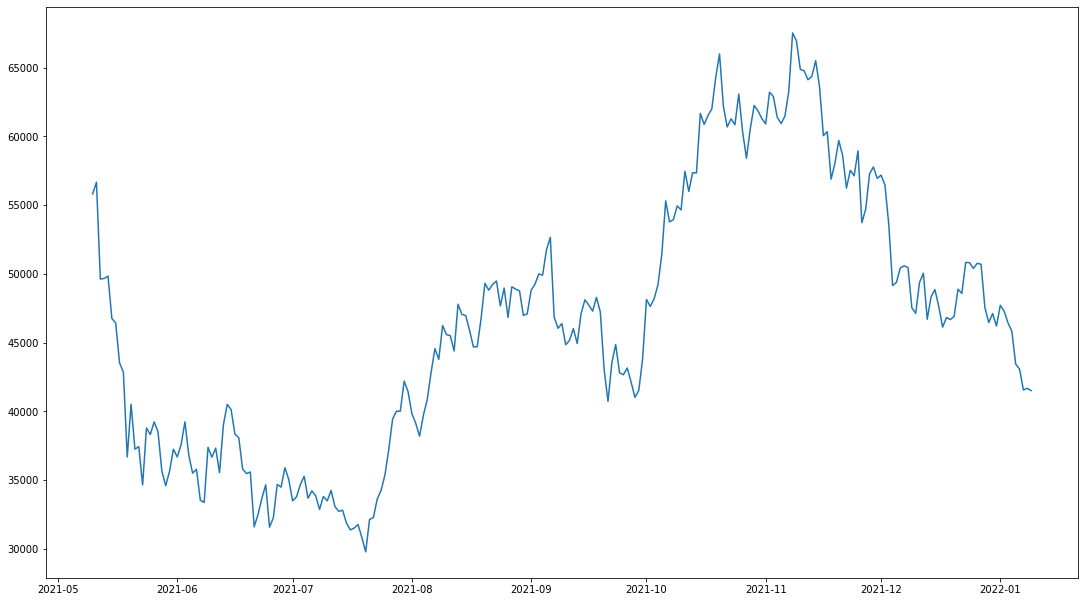

In [15]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(market["date"],market["btc"])

In [68]:
training_start = datetime(2021,5,1)
training_end = datetime(2021,10,1)
symbols = [x for x in market.columns if x not in ["date","crypto"]]
information_days = 8
sims = []
for symbol in tqdm(symbols):
    try:
        print(symbol)
        symbol_data = market[["date",symbol]]
        symbol_data.sort_values("date",inplace=True)
        for i in range(1,information_days):
            symbol_data[str(i)] = symbol_data[symbol].shift(i)
        symbol_data.dropna(inplace=True)
        symbol_data.rename(columns={symbol:"y"},inplace=True)
        training_data = symbol_data[(symbol_data["date"]>=training_start) & (symbol_data["date"]<training_end)]
        training_data.reset_index(inplace=True,drop=True)
        prediction_data = symbol_data[(symbol_data["date"]>training_end)]
        factors = [str(i) for i in range(1,information_days)]
        refined = {"X":training_data[factors],"y":training_data[["y"]]}
        models = m.regression(refined)
        for row in models.iterrows():
            sim = prediction_data 
            current_model = row[1]["model"]
            api = row[1]["api"]
            score = row[1]["score"]
            if score > 0.7:
                predictions = current_model.predict(prediction_data[factors])
                sim[f'{api}_prediction'] = predictions
        sim["prediction"] = [mean(row[1][column] for column in [x for x in sim.columns if "prediction" in x]) for row in sim.iterrows()]
        sim["symbol"] = symbol
        sims.append(sim)
    except Exception as e:
        print(str(e))

  0%|                   | 0/12 [00:00<?, ?it/s]

ada


  8%|▉          | 1/12 [00:04<00:45,  4.15s/it]

avax


 17%|█▊         | 2/12 [00:08<00:42,  4.25s/it]

btc


 25%|██▊        | 3/12 [00:13<00:39,  4.42s/it]

cake


 33%|███▋       | 4/12 [00:17<00:34,  4.37s/it]

doge


 42%|████▌      | 5/12 [00:21<00:29,  4.26s/it]

dot


 50%|█████▌     | 6/12 [00:25<00:25,  4.29s/it]

eth


 58%|██████▍    | 7/12 [00:30<00:21,  4.34s/it]

ltc


 67%|███████▎   | 8/12 [00:34<00:17,  4.31s/it]

luna


 75%|████████▎  | 9/12 [00:38<00:13,  4.34s/it]

shib


 83%|████████▎ | 10/12 [00:43<00:08,  4.28s/it]

xrp


 92%|█████████▏| 11/12 [00:47<00:04,  4.23s/it]

xtz


100%|██████████| 12/12 [00:51<00:00,  4.29s/it]


In [69]:
final = pd.concat(sims)

In [70]:
final["symbol"].unique()

array(['ada', 'avax', 'btc', 'cake', 'doge', 'dot', 'eth', 'ltc', 'luna',
       'shib', 'xrp', 'xtz'], dtype=object)

In [71]:
final

crypto,date,y,1,2,3,4,5,6,7,skl_prediction,xgb_prediction,cat_prediction,prediction,symbol
900,2021-10-02,2.247,2.256,2.115,2.066,2.037,2.130,2.207,2.300,2.218145,2.148624,2.331584,2.232784,ada
901,2021-10-03,2.251,2.247,2.256,2.115,2.066,2.037,2.130,2.207,2.216681,2.152196,2.263462,2.210779,ada
902,2021-10-04,2.191,2.251,2.247,2.256,2.115,2.066,2.037,2.130,2.222209,2.201550,2.289174,2.237644,ada
903,2021-10-05,2.233,2.191,2.251,2.247,2.256,2.115,2.066,2.037,2.203166,2.187847,2.221521,2.204178,ada
904,2021-10-06,2.209,2.233,2.191,2.251,2.247,2.256,2.115,2.066,2.223223,2.232525,2.229279,2.228342,ada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-01-05,4.509,5.043,4.803,4.654,4.746,4.340,4.344,4.373,4.984111,4.810473,5.148144,4.980909,xtz
996,2022-01-06,4.452,4.509,5.043,4.803,4.654,4.746,4.340,4.344,4.407883,4.592759,5.104406,4.701683,xtz
997,2022-01-07,4.253,4.452,4.509,5.043,4.803,4.654,4.746,4.340,4.420191,4.451263,5.053674,4.641709,xtz
998,2022-01-08,4.005,4.253,4.452,4.509,5.043,4.803,4.654,4.746,4.237790,4.299376,4.902228,4.479798,xtz


,date,open,high,low,close,volume,market_cap,crypto,y,1,2,3,4,5,6,7,skl_prediction,xgb_prediction,cat_prediction,prediction


In [76]:
prices = p.column_date_processing(prices)

In [81]:
final.rename(columns={"y":"close"},inplace=True,errors="ignore")

In [82]:
final["signal"] = (final["prediction"] - final["close"]) / final["close"]

In [83]:
final

crypto,date,close,1,2,3,4,5,6,7,skl_prediction,xgb_prediction,cat_prediction,prediction,symbol,signal
900,2021-10-02,2.247,2.256,2.115,2.066,2.037,2.130,2.207,2.300,2.218145,2.148624,2.331584,2.232784,ada,-0.006326
901,2021-10-03,2.251,2.247,2.256,2.115,2.066,2.037,2.130,2.207,2.216681,2.152196,2.263462,2.210779,ada,-0.017868
902,2021-10-04,2.191,2.251,2.247,2.256,2.115,2.066,2.037,2.130,2.222209,2.201550,2.289174,2.237644,ada,0.021289
903,2021-10-05,2.233,2.191,2.251,2.247,2.256,2.115,2.066,2.037,2.203166,2.187847,2.221521,2.204178,ada,-0.012907
904,2021-10-06,2.209,2.233,2.191,2.251,2.247,2.256,2.115,2.066,2.223223,2.232525,2.229279,2.228342,ada,0.008756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-01-05,4.509,5.043,4.803,4.654,4.746,4.340,4.344,4.373,4.984111,4.810473,5.148144,4.980909,xtz,0.104659
996,2022-01-06,4.452,4.509,5.043,4.803,4.654,4.746,4.340,4.344,4.407883,4.592759,5.104406,4.701683,xtz,0.056083
997,2022-01-07,4.253,4.452,4.509,5.043,4.803,4.654,4.746,4.340,4.420191,4.451263,5.053674,4.641709,xtz,0.091397
998,2022-01-08,4.005,4.253,4.452,4.509,5.043,4.803,4.654,4.746,4.237790,4.299376,4.902228,4.479798,xtz,0.118551


In [84]:
market = final.copy()

In [95]:
market

crypto,date,close,1,2,3,4,5,6,7,skl_prediction,xgb_prediction,cat_prediction,prediction,symbol,signal
900,2021-10-02,2.247,2.256,2.115,2.066,2.037,2.130,2.207,2.300,2.218145,2.148624,2.331584,2.232784,ada,-0.006326
901,2021-10-03,2.251,2.247,2.256,2.115,2.066,2.037,2.130,2.207,2.216681,2.152196,2.263462,2.210779,ada,-0.017868
902,2021-10-04,2.191,2.251,2.247,2.256,2.115,2.066,2.037,2.130,2.222209,2.201550,2.289174,2.237644,ada,0.021289
903,2021-10-05,2.233,2.191,2.251,2.247,2.256,2.115,2.066,2.037,2.203166,2.187847,2.221521,2.204178,ada,-0.012907
904,2021-10-06,2.209,2.233,2.191,2.251,2.247,2.256,2.115,2.066,2.223223,2.232525,2.229279,2.228342,ada,0.008756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-01-05,4.509,5.043,4.803,4.654,4.746,4.340,4.344,4.373,4.984111,4.810473,5.148144,4.980909,xtz,0.104659
996,2022-01-06,4.452,4.509,5.043,4.803,4.654,4.746,4.340,4.344,4.407883,4.592759,5.104406,4.701683,xtz,0.056083
997,2022-01-07,4.253,4.452,4.509,5.043,4.803,4.654,4.746,4.340,4.420191,4.451263,5.053674,4.641709,xtz,0.091397
998,2022-01-08,4.005,4.253,4.452,4.509,5.043,4.803,4.654,4.746,4.237790,4.299376,4.902228,4.479798,xtz,0.118551


In [105]:
symbol

991    luna
991    avax
991    shib
992    shib
992    luna
992    avax
993    luna
993    avax
993    shib
994    luna
994    shib
994    avax
995    shib
995    luna
995    avax
996    luna
996    shib
996    avax
997    shib
998    shib
998    luna
998    avax
999    luna
999    avax
999    shib
Name: symbol, dtype: object

In [107]:
retrack_days = [1,3,7,14]
signals = range(0,15,5)
reqs = range(5,15,5)
trades = []
start = datetime(2021,10,1)
end = datetime(2022,1,1)
for rt in tqdm(retrack_days):
    for s in tqdm(signals):
        for r in reqs:
            signal = float(s/100)
            req = float(r/100)
            date = start
            while date < end:
                try:
                    futures = market[market["date"]>date]
                    futures.sort_values("date",inplace=True)
                    entries = futures[(futures["signal"] <= -signal)]
                    if entries.index.size < 1:
                        if (end-date).days < rt:
                            break
                        else:
                            date = date + timedelta(days=1)
                    else:
                        trade = entries.iloc[0]
                        symbol = trade["symbol"]
                        exits = market[(market["symbol"]==symbol) & (market["date"]>trade["date"])]
                        bp = trade["close"]
                        exits["delta"] = (exits["close"] - bp) / bp
                        profits = exits[exits["delta"] >= req]
                        if profits.index.size < 1:
                            breakeven = exits[exits["delta"]>=0]
                            if breakeven.index.size < 1:
                                exit = exits.iloc[-1]
                                trade["sell_price"] = exit["close"]

                            else:
                                exit = breakeven.iloc[0]
                                trade["sell_price"] = bp
                        else:
                            exit = profits.iloc[0]
                            trade["sell_price"] = exit["close"]
                        trade["sell_date"] = exit["date"]
                        trade["buy_price"] = bp
                        trade["delta"] = (trade["sell_price"] - trade["buy_price"])/ trade["buy_price"]
                        trade["signal"] = signal
                        trade["req"] = req
                        trade["symbol"] = symbol
                        trade["retrack_days"] = rt
                        trade["api"] = api
                        trades.append(trade)
                        date = exit["date"] + timedelta(days=1)
                except Exception as e:
                    print(date,str(e))
                    date = date + timedelta(days=1)

100%|████████████| 4/4 [00:00<00:00,  4.90it/s]


In [108]:
t = pd.DataFrame(trades)

In [109]:
analysis = []
for rt in retrack_days:
    for s in tqdm(signals):
        for r in reqs:
            try:
                signal = float(s/100)
                req = float(r/100)
                iteration_trades = t[(t["signal"]==signal) & (t["req"]==req) & (t["retrack_days"]==rt)]
                initial = 100
                for delta in iteration_trades["delta"]:
                     initial = initial * (1+delta)
                iteration_trades["hpr"] = iteration_trades["sell_date"] - iteration_trades["date"]
                iteration_trades["days"] = [x.days for x in iteration_trades["hpr"]]
                days = iteration_trades["days"].mean()
                analysis.append({"signal":signal,"req":req,"trades":iteration_trades.index.size,"pv":initial,"days":days,"retrack_days":rt})
            except Exception as e:
                print(str(e))

100%|███████████| 3/3 [00:00<00:00, 374.94it/s]


In [110]:
a = pd.DataFrame(analysis)

In [112]:
a.sort_values("pv",ascending=False)

,signal,req,trades,pv,days,retrack_days
22,0.10,0.05,13,196.179520,5.769231,14
16,0.10,0.05,13,196.179520,5.769231,7
4,0.10,0.05,13,196.179520,5.769231,1
10,0.10,0.05,13,196.179520,5.769231,3
23,0.10,0.10,6,167.513930,14.833333,14
11,0.10,0.10,6,167.513930,14.833333,3
17,0.10,0.10,6,167.513930,14.833333,7
5,0.10,0.10,6,167.513930,14.833333,1
8,0.05,0.05,13,159.207920,5.769231,3
20,0.05,0.05,13,159.207920,5.769231,14


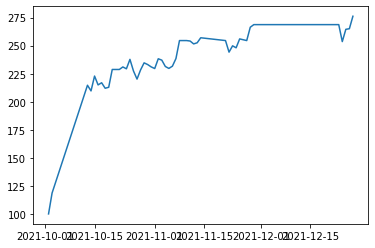

In [113]:
api = "alpha"
goods = a.sort_values("pv",ascending=False).head(10).iloc[0]
current_trades = t[(t["signal"]==goods["signal"].item())
                       & (t["req"]==goods["req"].item())
                        & (t["retrack_days"]==goods["retrack_days"].item())
                          
                  ]
current_trades.sort_values("sell_date",inplace=True)
if current_trades.index.size > 1:
    viz = []
    row = current_trades.iloc[0]
    pv = 100
    start_date = row["date"]
    symbol = row["symbol"]
    amount = float(pv/row["buy_price"])
    end_date = row["sell_date"]
    pv2 = amount * row["sell_price"]
    viz.append({"date":start_date,"crypto":symbol,"amount":amount})
    viz.append({"date":end_date,"crypto":symbol,"amount":amount})
    track_date = start_date
    while track_date < end_date - timedelta(days=1):
        track_date = track_date + timedelta(days=1)
        viz.append({"date":track_date,"crypto":symbol,"amount":amount})
    for i in range(1,current_trades.index.size-1):
        row = current_trades.iloc[i]
        symbol = current_trades.iloc[i]["symbol"]
        start_date = row["date"]
        pv = pv2
        amount =  pv /row["buy_price"]
        viz.append({"date":start_date,"crypto":symbol,"amount":amount})
        track_date = start_date
        end_date = row["sell_date"]
        while track_date < end_date:
            track_date = track_date + timedelta(days=1)
            viz.append({"date":track_date,"crypto":symbol,"amount":amount})
        pv2 = amount * row["sell_price"]
        viz.append({"date":end_date,"crypto":symbol,"amount":amount})
    window = pd.DataFrame(viz)
    example = final.rename(columns={"symbol":"crypto"}).merge(window,how="left",on=["date","crypto"])
    example = example.dropna().sort_values("date")
    example["actual"] = example["amount"] * example["close"]
#     example["bench_delta"] = (example["btc"] - example["btc"].iloc[0]) / example["btc"].iloc[0]
    example["actual_delta"] = (example["actual"] - example["actual"].iloc[0]) / example["actual"].iloc[0]
    plt.plot(example["date"],example["actual"])
#         plt.plot(example["date"],example["bench_delta"])
plt.show()

In [114]:
symbol_analysis = []
for symbol in current_trades["symbol"].unique():
    symbol_trades = current_trades[current_trades["symbol"]==symbol]
    trades = symbol_trades.index.size
    initial = 1
    for delta in symbol_trades["delta"]:
        initial = initial * 1+delta
    symbol_return = initial
    symbol_trades["hpr"] = symbol_trades["sell_date"] - symbol_trades["date"]
    symbol_trades["days"] = [x.days for x in symbol_trades["hpr"]]
    symbol_analysis.append({"symbol":symbol,"return":initial,"trades":trades,"hpr":symbol_trades["days"].mean()})

In [115]:
pd.DataFrame(symbol_analysis).sort_values("return",ascending=False)

,symbol,return,trades,hpr
1,shib,1.733893,4,2.00
0,xtz,1.186300,1,1.00
3,btc,1.168500,4,6.75
2,dot,1.065483,1,7.00
4,avax,1.000000,1,20.00
5,ada,1.000000,1,4.00
6,luna,0.729960,1,8.00
